In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# 如果浏览器不显示图片，就需要加上这句话
%matplotlib inline  

# 让图片中可以显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'   
# 让图片中可以显示负号
plt.rcParams['axes.unicode_minus'] = False  

# 支持svg矢量图
%config Inlinebackend.figure_format = 'svg'  

In [3]:
df_高考 = pd.read_csv('./视频数据/高考_视频数据.csv')
df_考研 = pd.read_csv('./视频数据/考研_视频数据.csv')
df_考公 = pd.read_csv('./视频数据/考公_视频数据.csv')
df_就业 = pd.read_csv('./视频数据/就业_视频数据.csv')

# 创建二级行索引
index_labels = ['高考'] * len(df_高考) + ['考研'] * len(df_考研) + ['考公'] * len(df_考公) + ['就业'] * len(df_就业)
merged_df = pd.concat([df_高考, df_考研, df_考公, df_就业]).reset_index(drop=True)
merged_df.index = pd.MultiIndex.from_arrays([index_labels, merged_df.index])

merged_df.head()

视频链接  \
高考 0  https://www.bilibili.com/video/BV1vk4y1p7TM?fr...   
   1  https://www.bilibili.com/video/BV1UP411D7z2?fr...   
   2  https://www.bilibili.com/video/BV1Qc41137ek?fr...   
   3  https://www.bilibili.com/video/BV1A14y1S7Zt?fr...   
   4  https://www.bilibili.com/video/BV1mW4y1X725?fr...   

                                 视频名称     总播放数  历史累计弹幕数                 上传时间  \
高考 0              史上最难高考来临，这届考生真的很不容易   234970      537  2023-06-09 17:30:00   
   1  200万粉福利特供|| 高考后的“分层之战”和“人生破圈算法”  1806733    13964  2023-06-06 10:00:00   
   2                     高考后，各个年级学生现状  1066212      849  2023-06-09 10:09:45   
   3                    今年高考数学，到底难不难？   698444     2589  2023-06-11 08:42:54   
   4               我国高考难度，最大和最小的几个省份！   258314     1743  2023-06-09 17:52:57   

        点赞数    投币数    收藏数    转发数  \
高考 0   9401    179   1340    638   
   1  20.6万  22.0万  15.2万  10.2万   
   2   2.9万   1251   1.1万   1273   
   3   3.4万   5477   9180   2186   
   4   5405    338   2074   2096   

                                                     标签  
高考 0                           高考,考试,知识,财经商业,学习,考生,史上最难  
   1  社会洞察计划,高考,知识,社科·法律·心理,星海计划,高三,大学,算法,学习,人生,经验分享...  
   2                            高考,生活,搞笑,大学,吐槽,真实,高中,初中  
   3  2023高考季,高考数学,高考,知识,校园学习,高三,数学,高考冲刺,高中数学,高中,一轮复...  
   4           UndyingLove,地理,高考,科普,知识,人文历史,家乡,高中,最大,省份

In [4]:
merged_df_概率 = merged_df[['总播放数', '历史累计弹幕数', '点赞数', '投币数', '收藏数', '转发数']]
merged_df_概率 = merged_df_概率.dropna()
merged_df_概率

总播放数  历史累计弹幕数    点赞数    投币数    收藏数    转发数
高考 0     234970      537   9401    179   1340    638
   1    1806733    13964  20.6万  22.0万  15.2万  10.2万
   2    1066212      849   2.9万   1251   1.1万   1273
   3     698444     2589   3.4万   5477   9180   2186
   4     258314     1743   5405    338   2074   2096
...         ...      ...    ...    ...    ...    ...
就业 378     9130       92    893    225    174      6
   379    89236       77   1895    102    639    240
   380   232826       91   2651     65    845    462
   381    52415       34    659     40    602    188
   382    38899      126   1816    769    427    255

[383 rows x 6 columns]

In [5]:
def convert_to_int(value):
    if '万' in value:
        value = value.rstrip('万')
        value = float(value) * 10000
    return int(value)

merged_df_概率.loc[merged_df_概率['点赞数'].str.contains('万', na=False), '点赞数'] = merged_df_概率.loc[merged_df_概率['点赞数'].str.contains('万', na=False), '点赞数'].apply(convert_to_int)
merged_df_概率.loc[merged_df_概率['投币数'].str.contains('万', na=False), '投币数'] = merged_df_概率.loc[merged_df_概率['投币数'].str.contains('万', na=False), '投币数'].apply(convert_to_int)
merged_df_概率.loc[merged_df_概率['收藏数'].str.contains('万', na=False), '收藏数'] = merged_df_概率.loc[merged_df_概率['收藏数'].str.contains('万', na=False), '收藏数'].apply(convert_to_int)
merged_df_概率.loc[merged_df_概率['转发数'].str.contains('万', na=False), '转发数'] = merged_df_概率.loc[merged_df_概率['转发数'].str.contains('万', na=False), '转发数'].apply(convert_to_int)
merged_df_概率.dtypes

总播放数        int64
历史累计弹幕数     int64
点赞数        object
投币数        object
收藏数        object
转发数        object
dtype: object

In [6]:
merged_df_概率 = merged_df_概率.astype(float)
merged_df_概率.dtypes

总播放数       float64
历史累计弹幕数    float64
点赞数        float64
投币数        float64
收藏数        float64
转发数        float64
dtype: object

In [7]:
merged_df_概率.loc[:, '弹幕率'] = merged_df_概率.loc[:, '历史累计弹幕数']/merged_df_概率.loc[:, '总播放数']
merged_df_概率.loc[:, '点赞率'] = merged_df_概率.loc[:, '点赞数']/merged_df_概率.loc[:, '总播放数']
merged_df_概率.loc[:, '投币率'] = merged_df_概率.loc[:, '投币数']/merged_df_概率.loc[:, '总播放数']
merged_df_概率.loc[:, '收藏率'] = merged_df_概率.loc[:, '收藏数']/merged_df_概率.loc[:, '总播放数']
merged_df_概率.loc[:, '转发率'] = merged_df_概率.loc[:, '转发数']/merged_df_概率.loc[:, '总播放数']
merged_df_概率 = merged_df_概率[['弹幕率', '点赞率', '投币率', '收藏率', '转发率']]
merged_df_概率

弹幕率       点赞率       投币率       收藏率       转发率
高考 0    0.002285  0.040009  0.000762  0.005703  0.002715
   1    0.007729  0.114018  0.121767  0.084130  0.056455
   2    0.000796  0.027199  0.001173  0.010317  0.001194
   3    0.003707  0.048680  0.007842  0.013144  0.003130
   4    0.006748  0.020924  0.001308  0.008029  0.008114
...          ...       ...       ...       ...       ...
就业 378  0.010077  0.097809  0.024644  0.019058  0.000657
   379  0.000863  0.021236  0.001143  0.007161  0.002689
   380  0.000391  0.011386  0.000279  0.003629  0.001984
   381  0.000649  0.012573  0.000763  0.011485  0.003587
   382  0.003239  0.046685  0.019769  0.010977  0.006555

[383 rows x 5 columns]

In [8]:
高考_df_概率 = merged_df_概率.loc['高考']
考研_df_概率 = merged_df_概率.loc['考研']
考公_df_概率 = merged_df_概率.loc['考公']
就业_df_概率 = merged_df_概率.loc['就业']
高考_df_概率

,弹幕率,点赞率,投币率,收藏率,转发率
0,0.002285,0.040009,0.000762,0.005703,0.002715
1,0.007729,0.114018,0.121767,0.084130,0.056455
2,0.000796,0.027199,0.001173,0.010317,0.001194
3,0.003707,0.048680,0.007842,0.013144,0.003130
4,0.006748,0.020924,0.001308,0.008029,0.008114
...,...,...,...,...,...
94,0.000327,0.102572,0.002338,0.004720,0.004090
95,0.003027,0.060782,0.018235,0.032128,0.004228
96,0.000255,0.174889,0.000534,0.005030,0.001503
97,0.012263,0.168707,0.008448,0.012613,0.002586


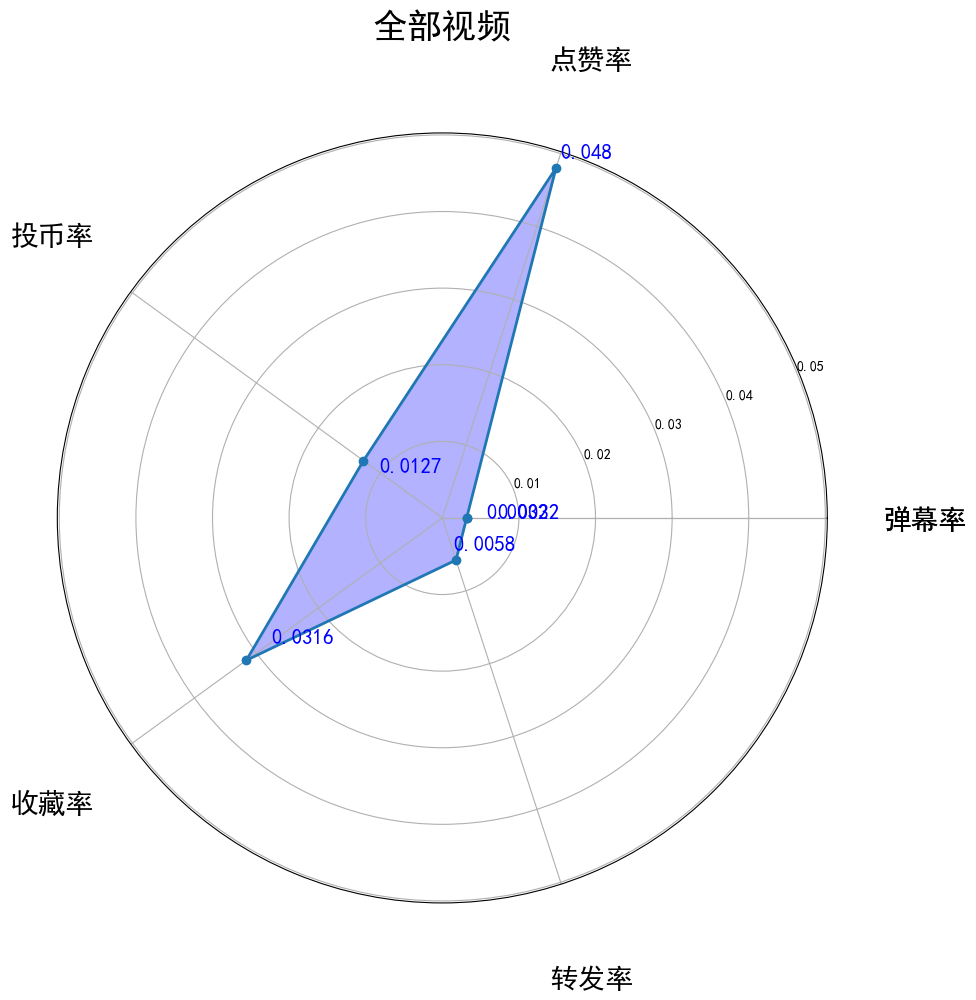

In [9]:
fig = plt.figure(figsize=(10, 10))

x = np.linspace(0, 2*np.pi, 5, endpoint=False)
labels = merged_df_概率.columns.tolist()
y_merged = merged_df_概率.mean().tolist()

# 保证首位相连
x = np.concatenate((x, [x[0]]))
labels = np.concatenate((labels, [labels[0]]))
y_merged = np.concatenate((y_merged, [y_merged[0]]))

# 雷达图
axes = plt.subplot(111, polar=True)   
axes.plot(x, y_merged, 'o-', linewidth=2)  # 连线
axes.fill(x, y_merged, color = 'blue', alpha=0.3)  # 填充

for i in range(len(x)):
    angle = np.deg2rad(i * 360 / len(x))
    label = labels[i]
    offset_radius = 0.004 # 文本标签相对于点的半径偏移量
    offset_angle = np.deg2rad(100)  # 文本标签相对于点的角度偏移量
    x_pos = x[i] + offset_radius * np.cos(angle + offset_angle)
    y_merged_pos = y_merged[i] + offset_radius * np.sin(angle + offset_angle)
    plt.annotate(str(round(y_merged[i], 4)), (x_pos, y_merged_pos), color = 'blue', fontsize = 15)



    
axes.set_thetagrids(x*180/np.pi, labels, fontsize = 20)
axes.xaxis.set_tick_params(pad=60)

plt.title('全部视频', fontsize=25)
    
plt.show()

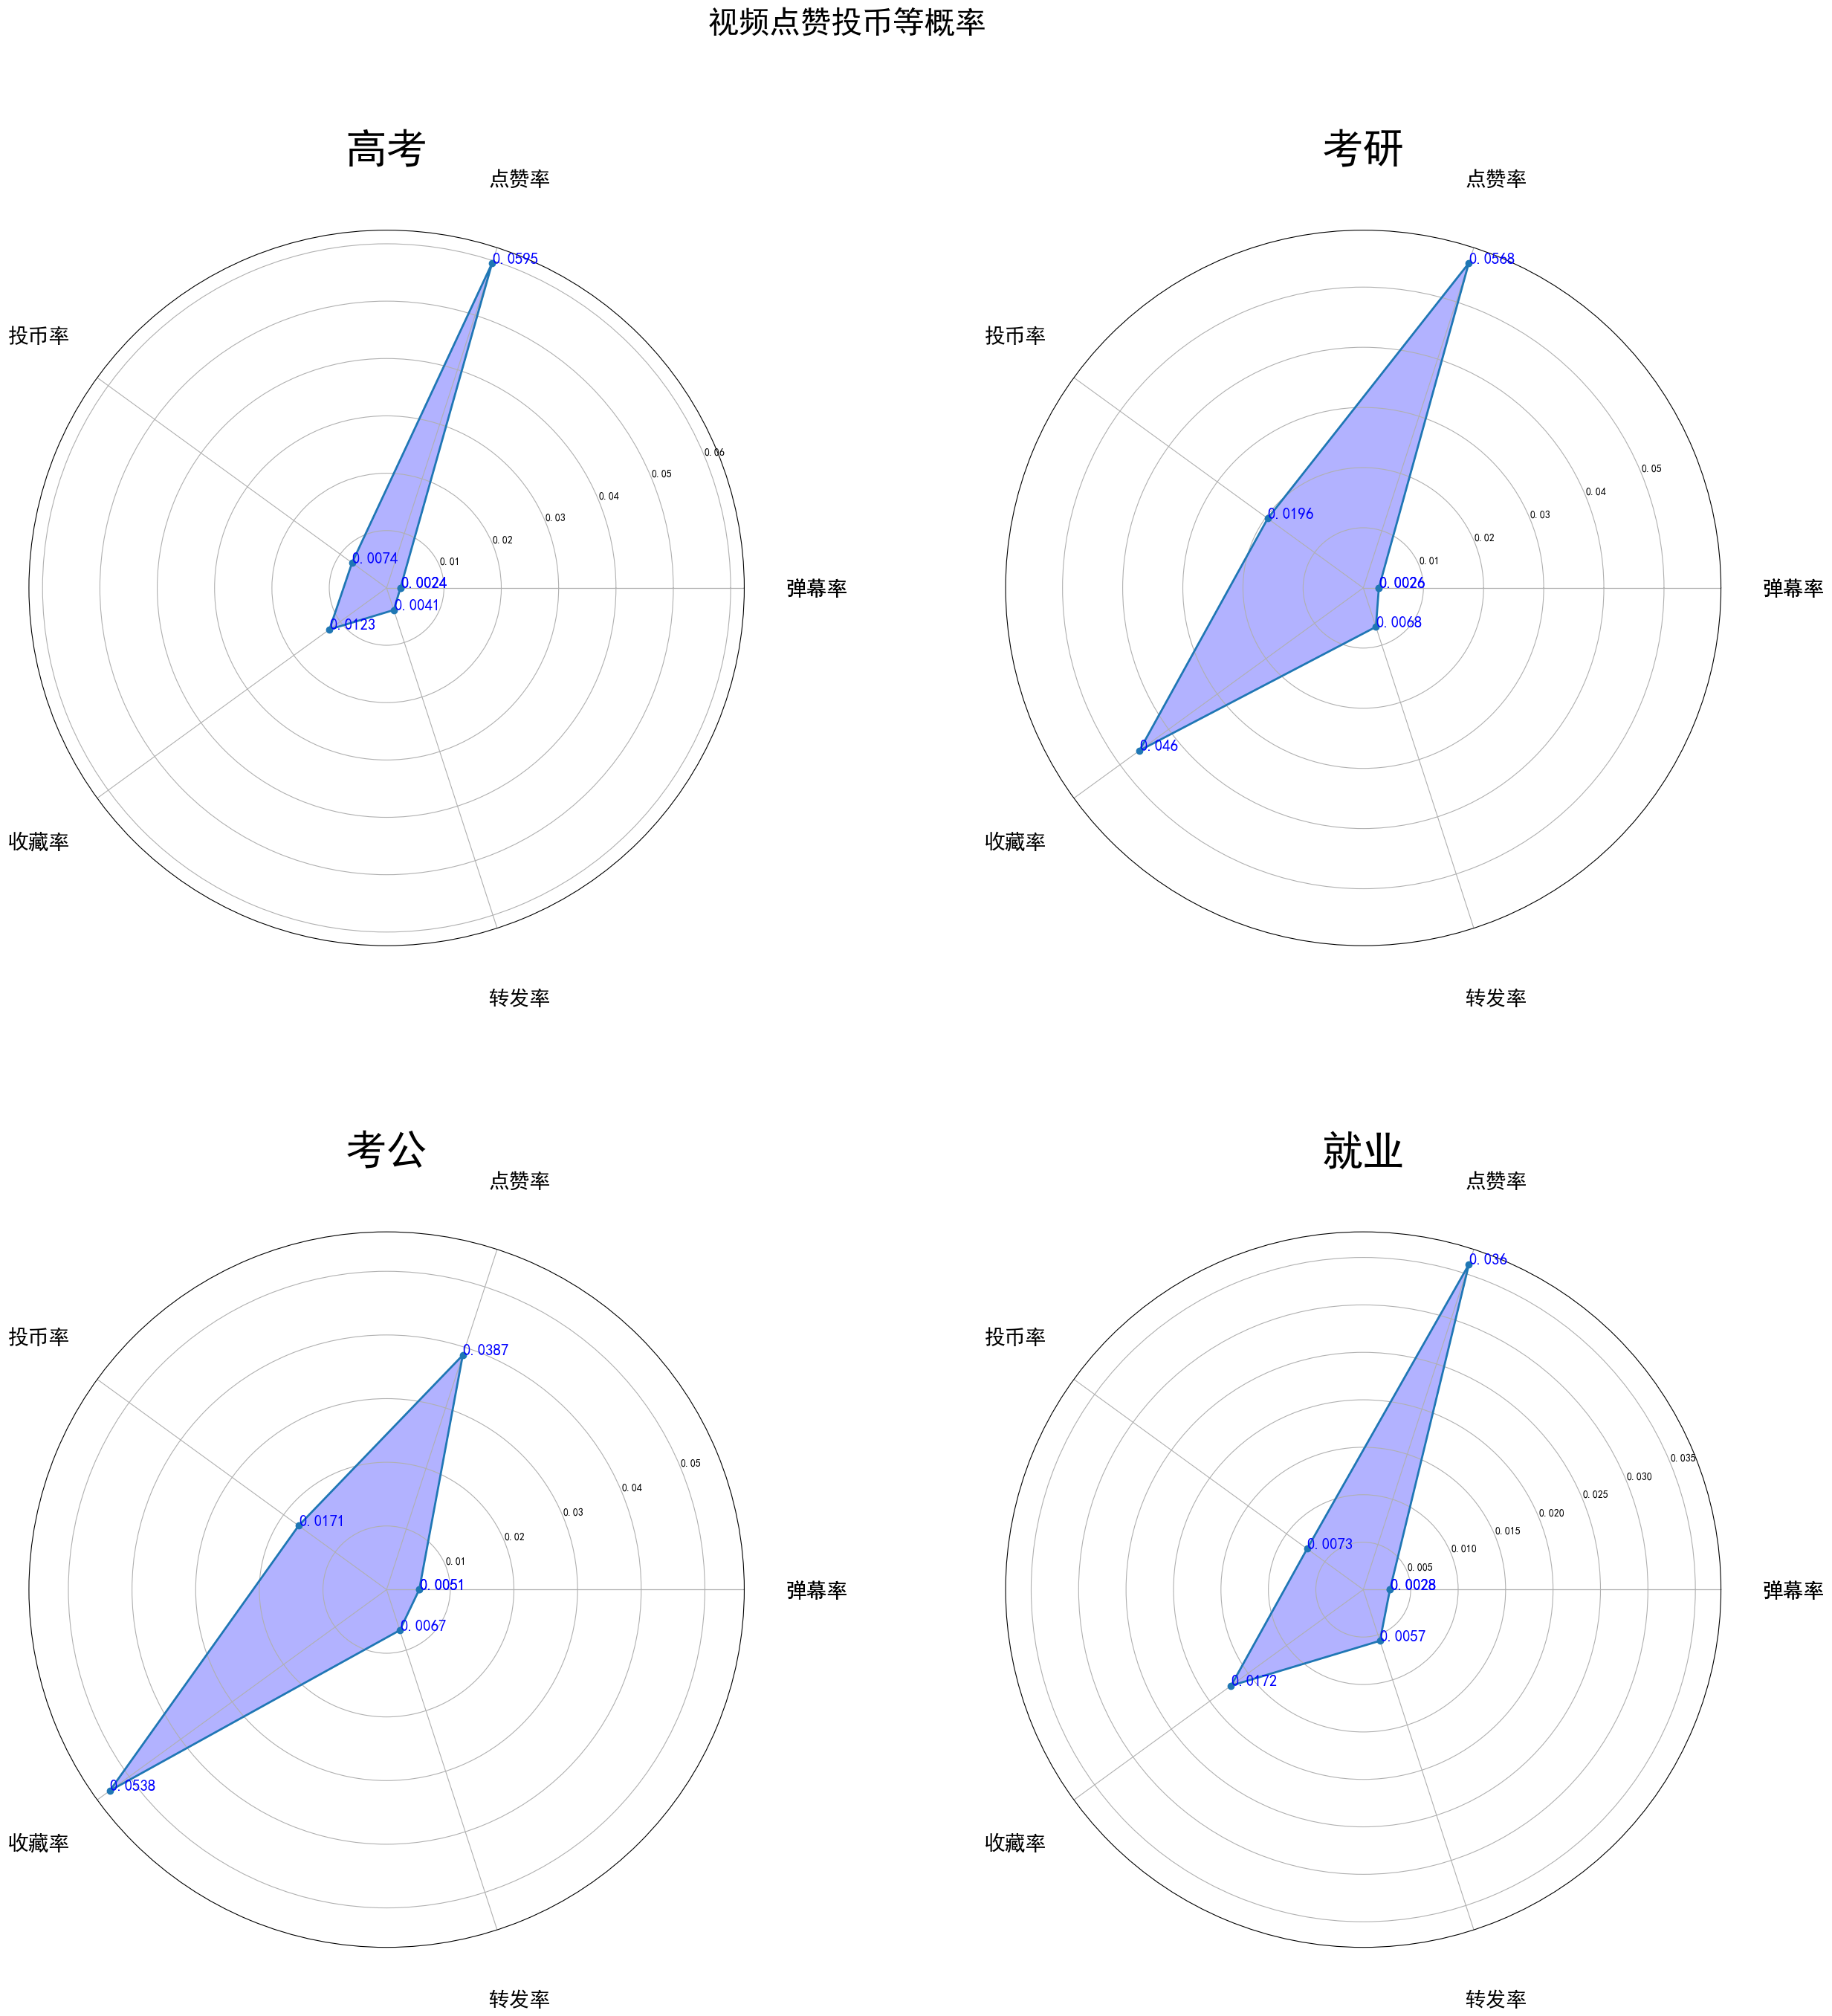

In [31]:
fig = plt.figure(figsize=(30, 30))

plt.suptitle('视频点赞投币等概率', fontsize=30)

# 第一个子图
axes1 = plt.subplot(221, polar=True)
x = np.linspace(0, 2*np.pi, 5, endpoint=False)
labels = merged_df_概率.columns.tolist()
# 保证首位相连
x = np.concatenate((x, [x[0]]))
labels = np.concatenate((labels, [labels[0]]))
y_高考 = 高考_df_概率.mean().tolist()
y_高考 = np.concatenate((y_高考, [y_高考[0]]))
axes1.plot(x, y_高考, 'o-', linewidth=2)
axes1.fill(x, y_高考, color='blue', alpha=0.3)

for i in range(len(x)):
    label = labels[i]
    x_pos = x[i]
    y_高考_pos = y_高考[i]
    plt.annotate(str(round(y_高考[i], 4)), (x_pos, y_高考_pos), color = 'blue', fontsize = 15)
axes1.set_thetagrids(x*180/np.pi, labels, fontsize = 20)
axes1.xaxis.set_tick_params(pad=60)
plt.title('高考', fontsize=40)

# 第二个子图
axes2 = plt.subplot(222, polar=True)
x = np.linspace(0, 2*np.pi, 5, endpoint=False)
labels = merged_df_概率.columns.tolist()
# 保证首位相连
x = np.concatenate((x, [x[0]]))
labels = np.concatenate((labels, [labels[0]]))
y_考研 = 考研_df_概率.mean().tolist()
y_考研 = np.concatenate((y_考研, [y_考研[0]]))
axes2.plot(x, y_考研, 'o-', linewidth=2)
axes2.fill(x, y_考研, color='blue', alpha=0.3)


for i in range(len(x)):
    label = labels[i]
    x_pos = x[i]
    y_考研_pos = y_考研[i]
    plt.annotate(str(round(y_考研[i], 4)), (x_pos, y_考研_pos), color = 'blue', fontsize = 15)
axes2.set_thetagrids(x*180/np.pi, labels, fontsize = 20)
axes2.xaxis.set_tick_params(pad=60)
plt.title('考研', fontsize=40)

# 第三个子图
axes3 = plt.subplot(223, polar=True)
x = np.linspace(0, 2*np.pi, 5, endpoint=False)
labels = merged_df_概率.columns.tolist()
# 保证首位相连
x = np.concatenate((x, [x[0]]))
labels = np.concatenate((labels, [labels[0]]))
y_考公 = 考公_df_概率.mean().tolist()
y_考公 = np.concatenate((y_考公, [y_考公[0]]))
axes3.plot(x, y_考公, 'o-', linewidth=2)
axes3.fill(x, y_考公, color='blue', alpha=0.3)

for i in range(len(x)):
    label = labels[i]
    x_pos = x[i]
    y_考公_pos = y_考公[i]
    plt.annotate(str(round(y_考公[i], 4)), (x_pos, y_考公_pos), color = 'blue', fontsize = 15)
axes3.set_thetagrids(x*180/np.pi, labels, fontsize = 20)
axes3.xaxis.set_tick_params(pad=60)
plt.title('考公', fontsize=40)

# 第四个子图
axes4 = plt.subplot(224, polar=True)
x = np.linspace(0, 2*np.pi, 5, endpoint=False)
labels = merged_df_概率.columns.tolist()
# 保证首位相连
x = np.concatenate((x, [x[0]]))
labels = np.concatenate((labels, [labels[0]]))
y_就业 = 就业_df_概率.mean().tolist()
y_就业 = np.concatenate((y_就业, [y_就业[0]]))
axes4.plot(x, y_就业, 'o-', linewidth=2)
axes4.fill(x, y_就业, color='blue', alpha=0.3)

for i in range(len(x)):
    label = labels[i]
    x_pos = x[i]
    y_就业_pos = y_就业[i]
    plt.annotate(str(round(y_就业[i], 4)), (x_pos, y_就业_pos), color = 'blue', fontsize = 15)
axes4.set_thetagrids(x*180/np.pi, labels, fontsize = 20)
axes4.xaxis.set_tick_params(pad=60)
plt.title('就业', fontsize=40)

# 调整子图之间的间距和布局
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# 显示图形
plt.show()


In [11]:
merged_df_time = merged_df.copy()
merged_df_time.head()

视频链接  \
高考 0  https://www.bilibili.com/video/BV1vk4y1p7TM?fr...   
   1  https://www.bilibili.com/video/BV1UP411D7z2?fr...   
   2  https://www.bilibili.com/video/BV1Qc41137ek?fr...   
   3  https://www.bilibili.com/video/BV1A14y1S7Zt?fr...   
   4  https://www.bilibili.com/video/BV1mW4y1X725?fr...   

                                 视频名称     总播放数  历史累计弹幕数                 上传时间  \
高考 0              史上最难高考来临，这届考生真的很不容易   234970      537  2023-06-09 17:30:00   
   1  200万粉福利特供|| 高考后的“分层之战”和“人生破圈算法”  1806733    13964  2023-06-06 10:00:00   
   2                     高考后，各个年级学生现状  1066212      849  2023-06-09 10:09:45   
   3                    今年高考数学，到底难不难？   698444     2589  2023-06-11 08:42:54   
   4               我国高考难度，最大和最小的几个省份！   258314     1743  2023-06-09 17:52:57   

        点赞数    投币数    收藏数    转发数  \
高考 0   9401    179   1340    638   
   1  20.6万  22.0万  15.2万  10.2万   
   2   2.9万   1251   1.1万   1273   
   3   3.4万   5477   9180   2186   
   4   5405    338   2074   2096   

                                                     标签  
高考 0                           高考,考试,知识,财经商业,学习,考生,史上最难  
   1  社会洞察计划,高考,知识,社科·法律·心理,星海计划,高三,大学,算法,学习,人生,经验分享...  
   2                            高考,生活,搞笑,大学,吐槽,真实,高中,初中  
   3  2023高考季,高考数学,高考,知识,校园学习,高三,数学,高考冲刺,高中数学,高中,一轮复...  
   4           UndyingLove,地理,高考,科普,知识,人文历史,家乡,高中,最大,省份

In [12]:
merged_df_time['上传时间'] = pd.to_datetime(merged_df_time['上传时间'])
merged_df_time['月份'] = merged_df_time['上传时间'].dt.month
高考_df_time = merged_df_time.loc['高考']
考研_df_time = merged_df_time.loc['考研']
考公_df_time = merged_df_time.loc['考公']
就业_df_time = merged_df_time.loc['就业']

merged_df_time.head()

视频链接  \
高考 0  https://www.bilibili.com/video/BV1vk4y1p7TM?fr...   
   1  https://www.bilibili.com/video/BV1UP411D7z2?fr...   
   2  https://www.bilibili.com/video/BV1Qc41137ek?fr...   
   3  https://www.bilibili.com/video/BV1A14y1S7Zt?fr...   
   4  https://www.bilibili.com/video/BV1mW4y1X725?fr...   

                                 视频名称     总播放数  历史累计弹幕数                上传时间  \
高考 0              史上最难高考来临，这届考生真的很不容易   234970      537 2023-06-09 17:30:00   
   1  200万粉福利特供|| 高考后的“分层之战”和“人生破圈算法”  1806733    13964 2023-06-06 10:00:00   
   2                     高考后，各个年级学生现状  1066212      849 2023-06-09 10:09:45   
   3                    今年高考数学，到底难不难？   698444     2589 2023-06-11 08:42:54   
   4               我国高考难度，最大和最小的几个省份！   258314     1743 2023-06-09 17:52:57   

        点赞数    投币数    收藏数    转发数  \
高考 0   9401    179   1340    638   
   1  20.6万  22.0万  15.2万  10.2万   
   2   2.9万   1251   1.1万   1273   
   3   3.4万   5477   9180   2186   
   4   5405    338   2074   2096   

                                                     标签  月份  
高考 0                           高考,考试,知识,财经商业,学习,考生,史上最难   6  
   1  社会洞察计划,高考,知识,社科·法律·心理,星海计划,高三,大学,算法,学习,人生,经验分享...   6  
   2                            高考,生活,搞笑,大学,吐槽,真实,高中,初中   6  
   3  2023高考季,高考数学,高考,知识,校园学习,高三,数学,高考冲刺,高中数学,高中,一轮复...   6  
   4           UndyingLove,地理,高考,科普,知识,人文历史,家乡,高中,最大,省份   6

In [13]:
group_month = merged_df_time[['总播放数', '月份']].groupby('月份').sum()
高考_month = 高考_df_time[['总播放数', '月份']].groupby('月份').sum()
考研_month = 考研_df_time[['总播放数', '月份']].groupby('月份').sum()
考公_month = 考公_df_time[['总播放数', '月份']].groupby('月份').sum()
就业_month = 就业_df_time[['总播放数', '月份']].groupby('月份').sum()
高考_month

,总播放数
月份,
1,986589
2,3877741
3,4104967
4,4163463
5,4223633
6,93445263
7,6226024
9,1548510


In [14]:
video_counts = merged_df_time.groupby('月份').size().reset_index(name='视频数量')
高考_video_counts = 高考_df_time.groupby('月份').size().reset_index(name='视频数量')
考研_video_counts = 考研_df_time.groupby('月份').size().reset_index(name='视频数量')
考公_video_counts = 考公_df_time.groupby('月份').size().reset_index(name='视频数量')
就业_video_counts = 就业_df_time.groupby('月份').size().reset_index(name='视频数量')
video_counts

,月份,视频数量
0,1,17
1,2,21
2,3,43
3,4,35
4,5,43
5,6,157
6,7,14
7,8,9
8,9,11
9,10,8


In [15]:
result = pd.merge(group_month, video_counts, on='月份')
高考_result = pd.merge(高考_month, 高考_video_counts, on='月份')
考研_result = pd.merge(考研_month, 考研_video_counts, on='月份')
考公_result = pd.merge(考公_month, 考公_video_counts, on='月份')
就业_result = pd.merge(就业_month, 就业_video_counts, on='月份')
complete_months = pd.DataFrame({'月份': range(1, 13)})
result = complete_months.merge(result, on='月份', how='left').fillna(0)
高考_result = complete_months.merge(高考_result, on='月份', how='left').fillna(0)
考研_result = complete_months.merge(考研_result, on='月份', how='left').fillna(0)
考公_result = complete_months.merge(考公_result, on='月份', how='left').fillna(0)
就业_result = complete_months.merge(就业_result, on='月份', how='left').fillna(0)
result

,月份,总播放数,视频数量
0,1,13609380,17
1,2,10485304,21
2,3,15487182,43
3,4,16738198,35
4,5,17410669,43
5,6,103084804,157
6,7,20868542,14
7,8,5377756,9
8,9,10360093,11
9,10,3814058,8


In [16]:
x = result['月份']
y11 = result['总播放数']
y12 = result['视频数量']
y21 = 高考_result['总播放数']
y22 = 高考_result['视频数量']
y31 = 考研_result['总播放数']
y32 = 考研_result['视频数量']
y41 = 考公_result['总播放数']
y42 = 考公_result['视频数量']
y51 = 就业_result['总播放数']
y52 = 就业_result['视频数量']
y11

0      13609380
1      10485304
2      15487182
3      16738198
4      17410669
5     103084804
6      20868542
7       5377756
8      10360093
9       3814058
10     10022838
11     27812870
Name: 总播放数, dtype: int64

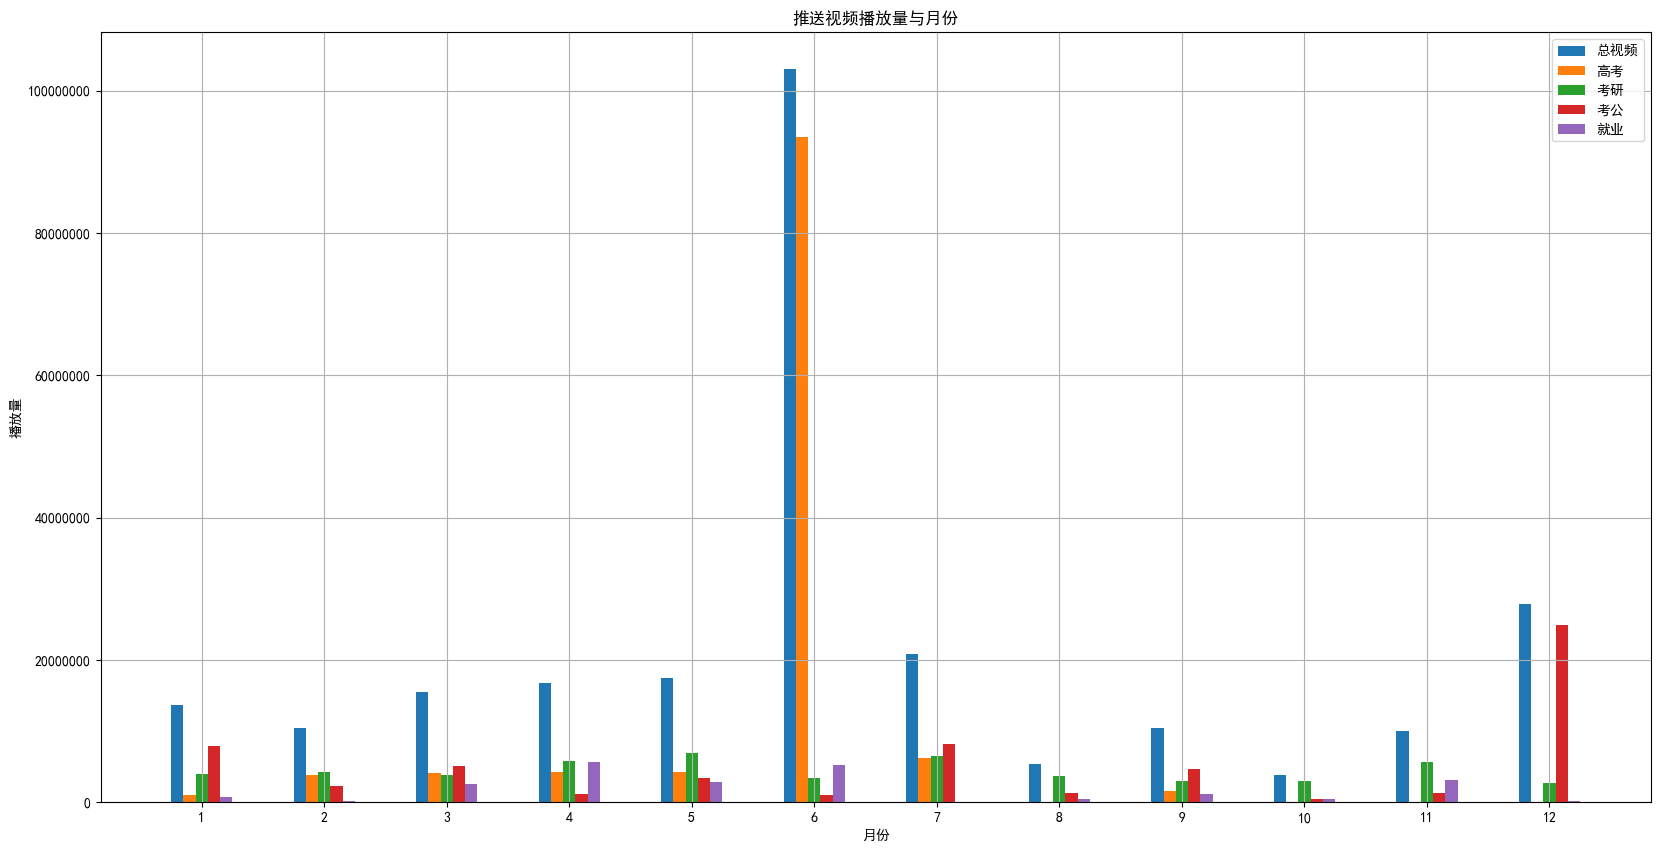

In [17]:
plt.figure(figsize=(20, 10))

plt.title('推送视频播放量与月份')
plt.xlabel('月份')
plt.ylabel('播放量')

width = 0.1
plt.bar(x - 2 * width, y11, width=width, label='总视频')
plt.bar(x - width, y21, width=width, label='高考')
plt.bar(x, y31, width=width, label='考研')
plt.bar(x + width, y41, width=width, label='考公')
plt.bar(x + 2 * width, y51, width=width, label='就业')

plt.legend()

# 设置 x 和 y 轴的刻度范围
plt.xticks(x)
# 设置 y 轴刻度标签的显示格式为完整的数值
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)

plt.show()


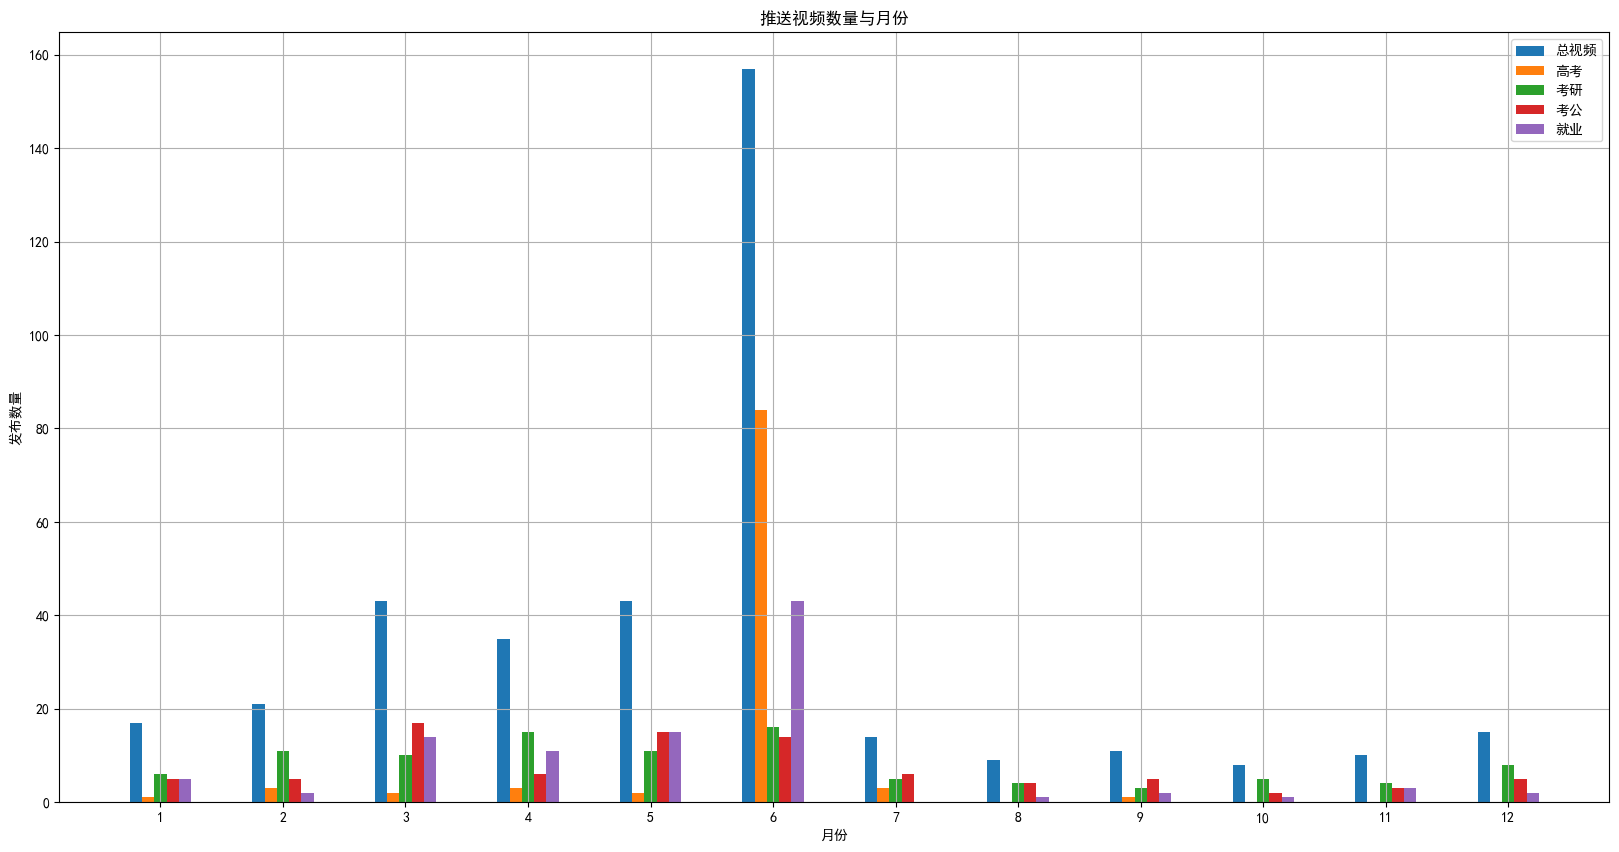

In [18]:
plt.figure(figsize=(20, 10))

plt.title('推送视频数量与月份')
plt.xlabel('月份')
plt.ylabel('发布数量')

width = 0.1
plt.bar(x - 2 * width, y12, width=width, label='总视频')
plt.bar(x - width, y22, width=width, label='高考')
plt.bar(x, y32, width=width, label='考研')
plt.bar(x + width, y42, width=width, label='考公')
plt.bar(x + 2 * width, y52, width=width, label='就业')

plt.legend()

# 设置 x 和 y 轴的刻度范围
plt.xticks(x)
# 设置 y 轴刻度标签的显示格式为完整的数值
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)

plt.show()


In [19]:
tag_df = merged_df['标签']
tag_df.head()

高考  0                             高考,考试,知识,财经商业,学习,考生,史上最难
    1    社会洞察计划,高考,知识,社科·法律·心理,星海计划,高三,大学,算法,学习,人生,经验分享...
    2                              高考,生活,搞笑,大学,吐槽,真实,高中,初中
    3    2023高考季,高考数学,高考,知识,校园学习,高三,数学,高考冲刺,高中数学,高中,一轮复...
    4             UndyingLove,地理,高考,科普,知识,人文历史,家乡,高中,最大,省份
Name: 标签, dtype: object

In [20]:
tag_高考 = tag_df['高考']
tag_考研 = tag_df['考研']
tag_考公 = tag_df['考公']
tag_就业 = tag_df['就业']

In [21]:
高考_words = tag_高考.str.split(',').explode()
高考_counts = 高考_words.value_counts()
高考_five_words = 高考_counts.head(5)
高考_five_words

考研_words = tag_考研.str.split(',').explode()
考研_counts = 考研_words.value_counts()
考研_five_words = 考研_counts.head(5)
考研_five_words

考公_words = tag_考公.str.split(',').explode()
考公_counts = 考公_words.value_counts()
考公_five_words = 考公_counts.head(5)
考公_five_words

就业_words = tag_就业.str.split(',').explode()
就业_counts = 就业_words.value_counts()
就业_five_words = 就业_counts.head(5)
高考_five_words

高考    93
搞笑    52
生活    50
知识    43
高中    32
Name: 标签, dtype: int64

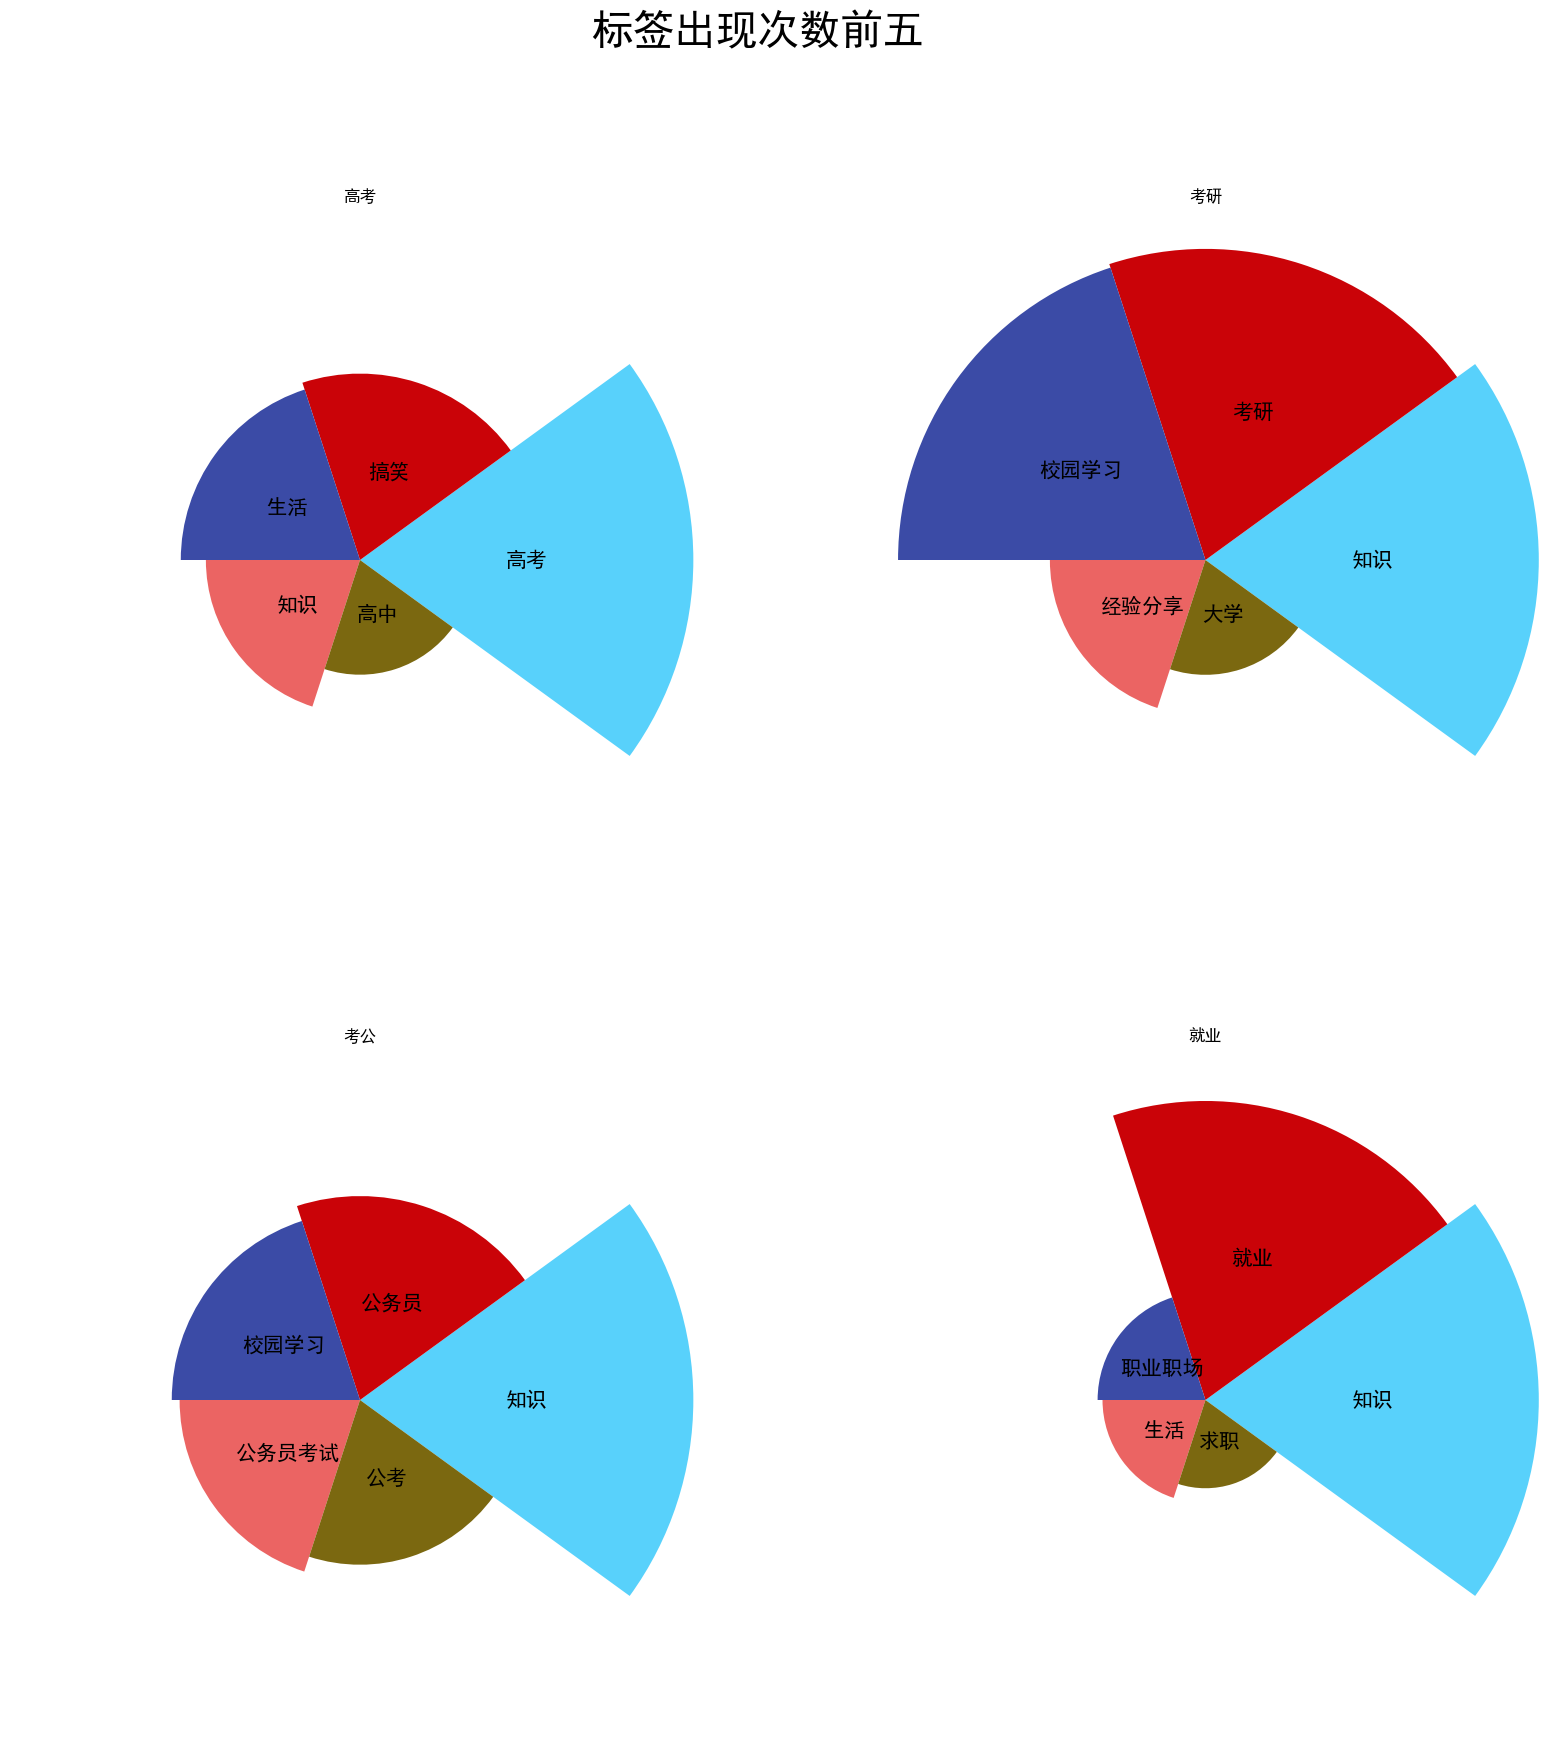

In [30]:
plt.figure(figsize=(20, 20))

plt.suptitle('标签出现次数前五', fontsize=30)
N = 5
x = np.linspace(0, 2*np.pi, N, endpoint=False)

width = 2*np.pi / 5  # 宽度
colors = np.random.rand(5, 3)  # 随机颜色

# polar表示极坐标
ax1 = plt.subplot(221, projection='polar')

plt.title('高考')

counts = 高考_five_words.values
words = 高考_five_words.index

# 去掉刻度
ax1.set_xticks([])
ax1.set_yticks([])

bars = ax1.bar(x=x, height=counts, width=width, bottom=0, color=colors)
ax1.spines['polar'].set_color('white')

# 添加标签
for i, bar in enumerate(bars):
    angle = x[i]
    height = bar.get_height()
    text_x = angle
    text_y = height / 2
    ax1.text(text_x, text_y, words[i], ha='center', va='center', fontsize=15)
    

# polar表示极坐标
ax2 = plt.subplot(222, projection='polar')

plt.title('考研')

counts = 考研_five_words.values
words = 考研_five_words.index

# 去掉刻度
ax2.set_xticks([])
ax2.set_yticks([])

bars = ax2.bar(x=x, height=counts, width=width, bottom=0, color=colors)
ax2.spines['polar'].set_color('white')

# 添加标签
for i, bar in enumerate(bars):
    angle = x[i]
    height = bar.get_height()
    text_x = angle
    text_y = height / 2
    ax2.text(text_x, text_y, words[i], ha='center', va='center', fontsize=15)
    
ax3 = plt.subplot(223, projection='polar')

plt.title('考公')

counts = 考公_five_words.values
words = 考公_five_words.index

# 去掉刻度
ax3.set_xticks([])
ax3.set_yticks([])

bars = ax3.bar(x=x, height=counts, width=width, bottom=0, color=colors)
ax3.spines['polar'].set_color('white')

# 添加标签
for i, bar in enumerate(bars):
    angle = x[i]
    height = bar.get_height()
    text_x = angle
    text_y = height / 2
    ax3.text(text_x, text_y, words[i], ha='center', va='center', fontsize=15)
    
ax4 = plt.subplot(224, projection='polar')

plt.title('就业')

counts = 就业_five_words.values
words = 就业_five_words.index

# 去掉刻度
ax4.set_xticks([])
ax4.set_yticks([])

bars = ax4.bar(x=x, height=counts, width=width, bottom=0, color=colors)
ax4.spines['polar'].set_color('white')

# 添加标签
for i, bar in enumerate(bars):
    angle = x[i]
    height = bar.get_height()
    text_x = angle
    text_y = height / 2
    ax4.text(text_x, text_y, words[i], ha='center', va='center', fontsize=15)


plt.show()
